## Импорты

стандартные библиотеки

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import folium

In [30]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

дополнительные импорты

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from geopy.geocoders import Nominatim
from IPython.display import display

чтобы никто не осуждал

In [32]:
import warnings
warnings.filterwarnings("ignore")

## Базовая информация о датасете

In [33]:
data = "./cities_economy_data.csv"

In [34]:
df = pd.read_csv(data, index_col=False, encoding="utf-8", sep=";")
df.head(20)

,City,Work,Price,Salary
0,Amsterdam,1714,"65,6",49
1,Athens,1792,"53,8","30,4"
2,Bogota,2152,"37,9","11,5"
3,Bombay,2052,"30,3","5,3"
4,Brussels,1708,"73,8","50,5"
5,Buenos_Aires,1971,"56,1","12,5"
6,Cairo,-9999,"37,1",-9999
7,Caracas,2041,61,"10,9"
8,Chicago,1924,"73,9","61,9"
9,Copenhagen,1717,"91,3","62,9"


In [35]:
df.replace(-9999, pd.NA, inplace=True)
df.dropna(inplace=True)
for col in ['Work', 'Price', 'Salary']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

df.head(20)

,City,Work,Price,Salary
0,Amsterdam,1714.0,65.6,49.0
1,Athens,1792.0,53.8,30.4
2,Bogota,2152.0,37.9,11.5
3,Bombay,2052.0,30.3,5.3
4,Brussels,1708.0,73.8,50.5
5,Buenos_Aires,1971.0,56.1,12.5
7,Caracas,2041.0,61.0,10.9
8,Chicago,1924.0,73.9,61.9
9,Copenhagen,1717.0,91.3,62.9
10,Dublin,1759.0,76.0,41.4


In [36]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 0 to 47
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    46 non-null     object 
 1   Work    46 non-null     float64
 2   Price   46 non-null     float64
 3   Salary  46 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.8+ KB


,Work,Price,Salary
count,46.000000,46.000000,46.000000
mean,1879.913043,70.100000,39.545652
std,174.342552,21.389177,24.757703
min,1583.000000,30.300000,2.700000
25%,1745.250000,51.775000,14.375000
50%,1849.000000,70.950000,43.650000
75%,1976.250000,81.900000,59.700000
max,2375.000000,115.500000,100.000000


## Разведочный анализ данных

<Axes: >

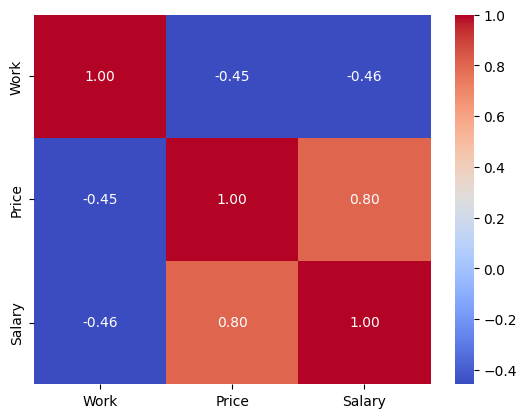

In [37]:
sns.heatmap(df[['Work', 'Price', 'Salary']].corr(), annot=True, cmap='coolwarm', fmt='.2f')

Из матрицы путаницы, представленной выше, видно, что есть зависимость цены от зарплаты, в то время как зависимость от кол-ва рабочих часов мала

Поскольку зависимость цены от заралпты более яркая, построим соответствующий график. Чтобы отобразить 3 переменную в виде кол-ва рабочих часов (Work), введём у каждой точки цвет и размерность. Для удобной визуализации воспользуемся библиотекой `ploty`, которая позволит интерактивно взаимодействавть с графиком и рассматривать конкретные области на графике, куда папало много городов.

In [38]:
fig = px.scatter(
    df,
    x='Price',
    y='Salary',
    text='City',
    size='Work',
    color='Work',
    hover_data=['Work', 'Price', 'Salary'],
    title='Зависимость Цен от Зарплаты (цвет = рабочие часы)',
    template='plotly_white'
)
fig.update_traces(textposition='top center')
fig.show()

Как видно на графике выше, большиенство городов находится в центре, что логично. Общая логика распределения городов соответствует тому, что цены на продукты тем выше, чем выше заработная плата. Также видно, что в основном города, имеющие более яркий оттенок, т.е. те, где среднее кол-во рабочих часов больше всего, в основном имеют меньшие зарпалты и цены на продукты (города в Индии, Малайзии, Филиппинах, Колумбии, ...). Однако, как и во многих видах данных, есть определённые выделяющиеся значения.

- Так, например, есть жёлтая точка чуть левее и ниже центра, которая соответствует Гонконгу. У этой точки самый яркий жёлтый цвет среди остальных значений. Такое расположение и цвет довольно легко объясняются, т.к. Гонконг находится в Китае, где стоимость труда часто ниже, а следовательно, низкое значение зарплаты на диаграмме; цены также ниже среднего, т.к. у Китая очень большой внутренний рынок, а следовательно и стоимость продуктов в среднем ниже; наконец, яркий жёлтый увет объясняется тем, что в Азиатских странах часто встречаются переработки.
- Видно, что среди городов с высокой зарплатой выделяется Европейские города.
- Если посмотреть на города, лидирующие по цене на продукты, то выделяются города Северной европы (Скандинавия). При этом, стоимость зарплата остаётся на том же уровне, что и у городов, расположенных в середине диаграммы. Это объясняется тем, что сами зарплаты у работников в основном больше, но существуют высокие налоги, которые делают чистый заработок меньше

Введём ещё один критерий, который позволит наглядно увидеть распределение городов. Этим критерием будет `Affordability` (доступность). Построим график, аналогичный тому, что был предлставлен выше, но с заменой параметра `Work` на `Affordability`

In [39]:
df['Affordability'] = df['Salary'] / df['Price']

fig = px.scatter(
    df,
    x='Price',
    y='Salary',
    text='City',
    size='Affordability',
    color='Affordability',
    color_continuous_scale='Viridis',
    hover_data=['Work', 'Affordability'],
    title='Зависимость Цен от Зарплаты (цвет = доступность жизни)',
    template='plotly_white'
)
fig.update_traces(textposition='top center')
fig.show()

Теперь стало чётко видно, что рост доступности жизни совпадает с ростом зарплат. Для большей наглядности проведу линии на графике ниже (параметры для параболы и линии подбирал вруную, чтобы они соответствовали реальному распределению по гоодам)

In [40]:
fig = px.scatter(
    df,
    x='Price',
    y='Salary',
    text='City',
    size='Affordability',
    color='Affordability',
    color_continuous_scale='Viridis',
    hover_data=['Work', 'Affordability'],
    title='Зависимость Цен от Зарплаты (цвет = доступность жизни)',
    template='plotly_white'
)

x_line = np.linspace(df['Price'].min(), df['Price'].max(), 200)

y_linear = 0.5 * x_line + 5

a, h, k = 0.02, 30, 10  # a — крутизна, h — смещение по X, k — смещение по Y
y_parabola = a * (x_line - h)**2 + k
mask = x_line > h
x_up = x_line[mask]
y_up = y_parabola[mask]

fig.add_trace(go.Scatter(
    x=x_line,
    y=y_linear,
    mode='lines',
    name='Линейная зависимость',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    x=x_up,
    y=y_up,
    mode='lines',
    name='Парабола',
    line=dict(color='blue', dash='dot')
))

fig.update_layout(
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.05,
        xanchor='center',
        x=1
    )
)

fig.update_traces(textposition='top center')
fig.show()

Теперь видно, что есть определённая зависимость цен на продукты от зарплат, при которой вне зависимости от одного из этих параметров, если сохраняется соотношение, то город будет комфортным для проживания. Это подтверждает одинаковый цвет точек (`Affordability`), расположенных на красной прямой.

Также есть синия линия, являющаяся параболой, котрая подтверждает, что при увеличении зарплат и меньшем увеличении цен на продукты растёт доступность жизни и урофень кофмфорта (`Affordability`), что тоже логично.

Дополнительное подтверждение зависимости доступности от цен и зарплат:

## Кластеризация

In [41]:
print(f'Количество городов: {len(df)}')

Количество городов: 46


В исходном наборе данных есть всего 46 городов, что не сравнится с большими датасетами, где есть 1 000, 10 000, 100 000 строк. В таких случаях лучше использовать иерархические методы с визуализацией в виде дендрограмм

Стандартизируем признаки

In [42]:
features = ["Work", "Price", "Salary", "Affordability"]
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Здесь видно, что учитывается параметр `Affordability`. Хотя его и нет в исходной таблице, он был добавлен, чтобы усилить зависимость от Salary и Price, а также чтобы получить распределение, включающее в себя доступность проживания в каждом из городов.

*upd: попробовал исопльзовать как только исходные параметры, так и с добавлением `Affortability`. Количество кластеров полуачется одно и тоже, однако шумов на графиках, исопльзуемых для подсчёта оптимального количества кластеров, гораздо меньше

In [43]:
df.head(10)

,City,Work,Price,Salary,Affordability
0,Amsterdam,1714.0,65.6,49.0,0.746951
1,Athens,1792.0,53.8,30.4,0.565056
2,Bogota,2152.0,37.9,11.5,0.303430
3,Bombay,2052.0,30.3,5.3,0.174917
4,Brussels,1708.0,73.8,50.5,0.684282
5,Buenos_Aires,1971.0,56.1,12.5,0.222816
7,Caracas,2041.0,61.0,10.9,0.178689
8,Chicago,1924.0,73.9,61.9,0.837618
9,Copenhagen,1717.0,91.3,62.9,0.688938
10,Dublin,1759.0,76.0,41.4,0.544737


Создадим упрощённую функцию, которая будет анлогом той, что исопльщовалась в 1 лабораторной работе

In [44]:
def evaluate_clustering(X, model_func, K_range, **kwargs):
    inertias, calinski, dbi, silhs = [], [], [], []

    for k in K_range:
        model = model_func(n_clusters=k, **kwargs).fit(X)
        labels = model.labels_
        
        inertia = getattr(model, 'inertia_', sum(np.sum((X[labels == i] - X[labels == i].mean(axis=0))**2) for i in range(k)))
        inertias.append(inertia)
        
        calinski.append(calinski_harabasz_score(X, labels))
        dbi.append(davies_bouldin_score(X, labels))
        silhs.append(silhouette_score(X, labels))

    fig, axs = plt.subplots(1, 4, figsize=(24,5))
    for ax, title, y, color in zip(axs, 
                                   ['Elbow', 'Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette Score'], 
                                   [inertias, calinski, dbi, silhs], 
                                   ['blue','green','red','purple']):
        ax.plot(K_range, y, '-o', color=color)
        ax.set_title(title)
        ax.set_xlabel('k')
        ax.set_ylabel('Score')
        ax.grid(True)
    plt.show()

Выберем диапазон кластеров k=2..10:
- k=1 не имеет смысла (весь датасет — один кластер)
- k=2...10 — промежуток, который будем рассматривать
- при k > 10 кластеры становятся слишком мелкими и теряют значимость

In [45]:
K_range = list(range(2, 11))

### Метод k-средних

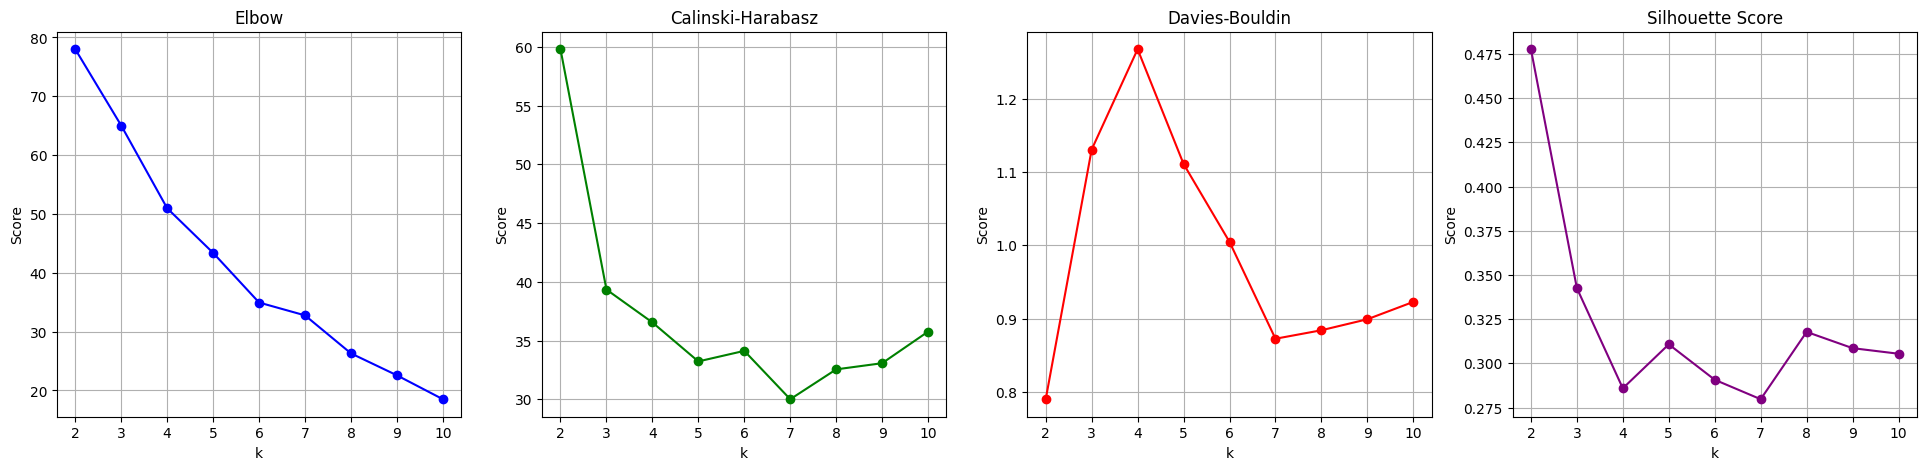

In [46]:
evaluate_clustering(X_scaled, KMeans, K_range, random_state=42)

KMeans плохо работает при малом числе объектов и сильно искажает форму кластеров при малом объёме данных, поэтому графики выше выводились, чтобы показать наглядно то, почему плохо использовать этот метод в данной ситуации. Однако, можно заметить локальные экстремумы в диапазоне от 4 до 6 кластеров. Брать бОльшее количество кластеров не будет исеть смысла, т.к. в этом случае получатся слишком локальные группы из нескольких городов, которые будут, скорее исключениями.

### Иерархическая кластеризация

Алгоритм работает "снизу вверх", начиная с того, что каждый город является отдельным кластером, и постепенно объединяет их в более крупные группы, ориентируясь на минимальное увеличение общей суммы квадратов отклонений внутри кластеров.

*Выбрал параметр `ward`, т.к. он минимизирует разброс внутри кластеров (внутрикластерную дисперсию), а не просто объединяет ближайшие точки, как это делают другие методы (single, complete или average linkage, про которые упоминал в предыдущей работе). Из-за этого `ward` формирует более "компактные" и устойчивые группы, где города действительно похожи по своим показателям (Work, Price, Salary), а не просто географически или случайно близки. Это важно, т.к. при построении облака точек в части с разведочным анализом были построены линии, которые показывают, что города распределены "пластами". Т.е. разброс по горизонтали может быть большой, а вертикальный меньше (чтобы понять, лучше заново обратиться к изображению в части с разведочным анализом)

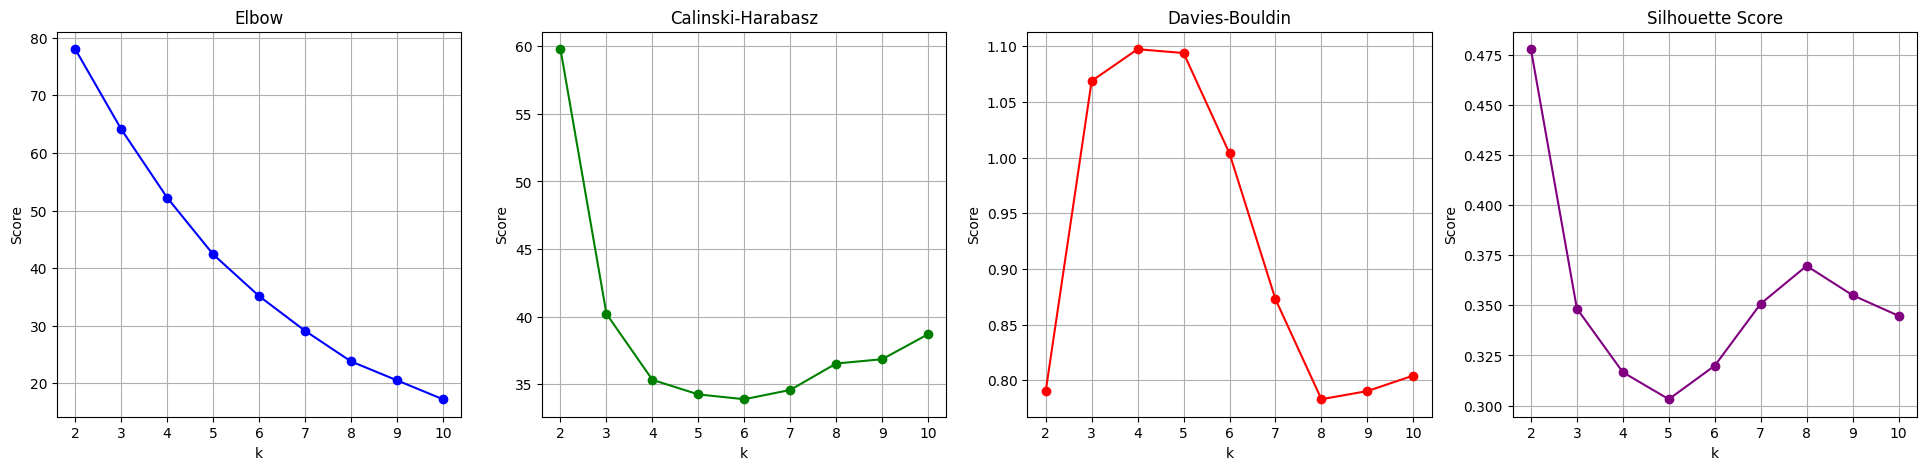

In [47]:
evaluate_clustering(X_scaled, AgglomerativeClustering, K_range, linkage='ward')

Как видно из полученных графиков, данныый метод рабюотает лучше. В отличие от KMeans, метод Ward даёт более устойчивое разбиение при небольшом количестве объектов (в нашем случае 46 городов). Однако по построенным графикам тоже не получится точно определить нужное количество кластеров, которое колеблится от 4 до 6 (`Calinski-Harabasz`: 6, `Davies-Bouldin`: 4, `Silhouette Score`: 5).

Чтобы получить более точные результаты, построим дендрограммы. Для этого воспользуемся функцией `dendrogram()` из `scipy.cluster.hierarchy` построим её с параметром `color_threshold=0`, который позволит сделать её одноцветной.

<details>
<summary>Пояснение dendrogram()</summary>

- На вход dendrogram() получает матрицу Z, созданную функцией linkage().
- Каждая ветвь на графике - кластер (группа городов).
- Горизонтальная ось - города.
- Вертикальная ось — это "расстояние" или "различие" между кластерами.
- Чем выше точка соединения, тем менее похожи города, которые были объединены.
- Если провести горизонтальную линию (например, `plt.axhline(y=4))`, она "разрежет" дерево на определённое число кластеров.

</details>

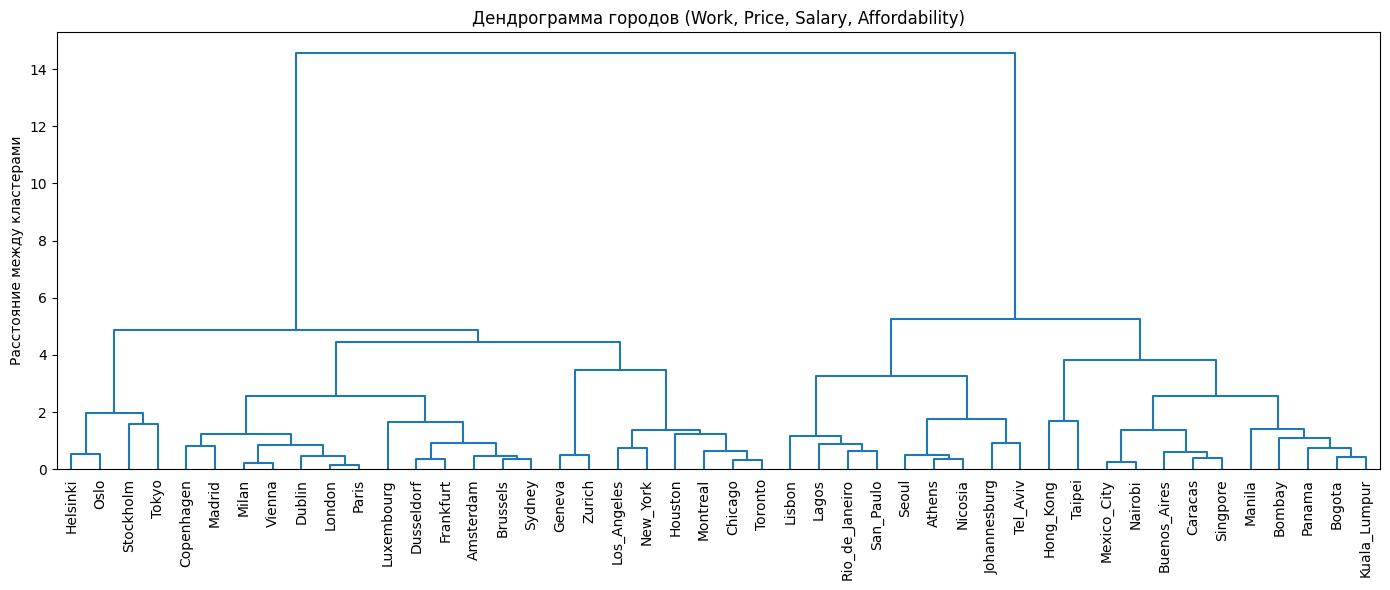

In [48]:
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df['City'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0  # делает все ветви одноцветными
)
plt.title(f"Дендрограмма городов ({', '.join(features)})")
plt.ylabel("Расстояние между кластерами")
plt.tight_layout()
plt.show()

Здесь видно, что наиболее оптимальным вариантом будет провести линию среза на высоте 5, 4 или 3

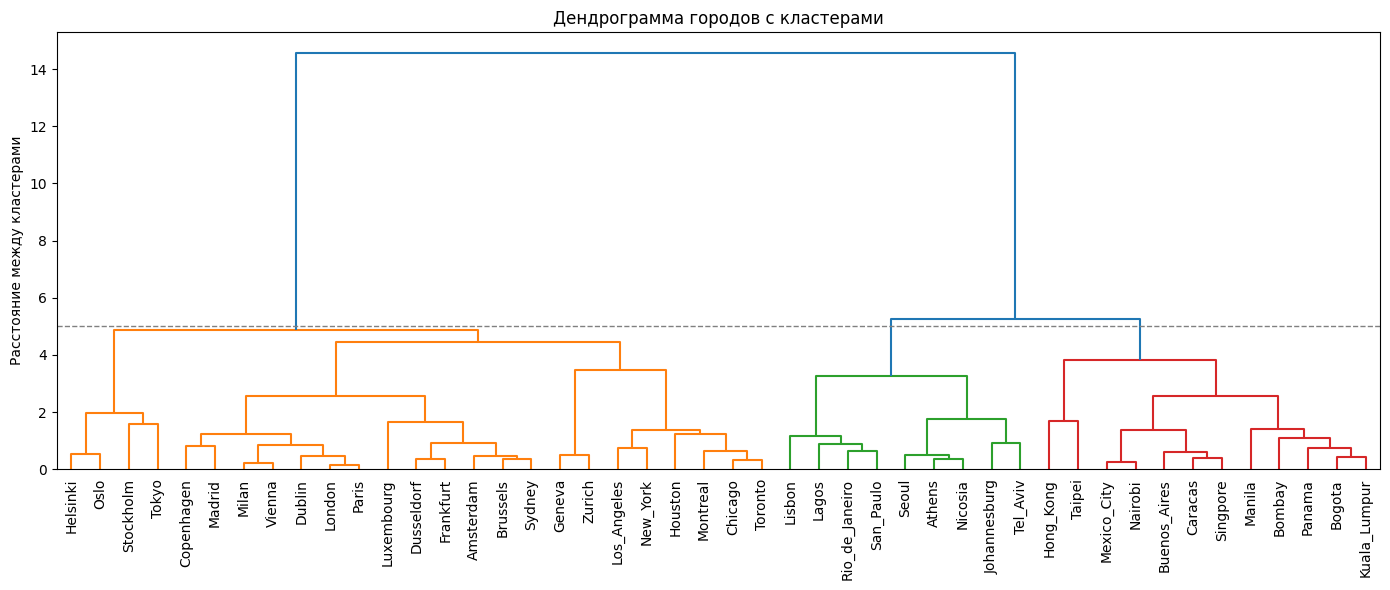

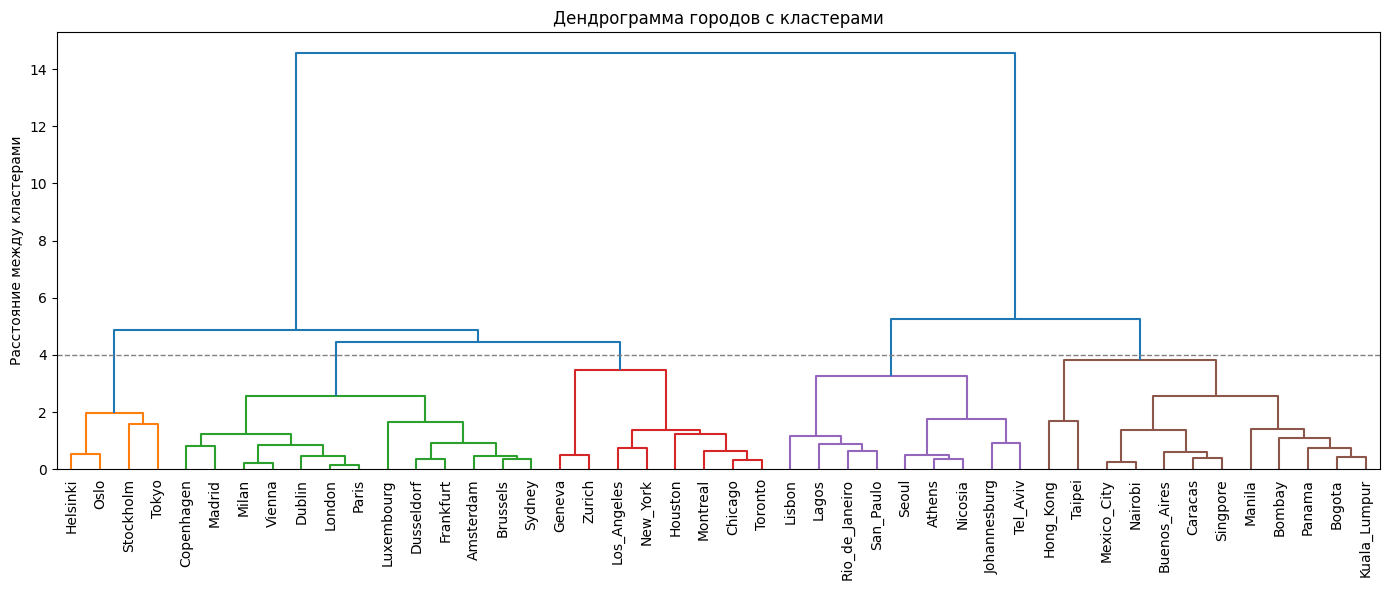

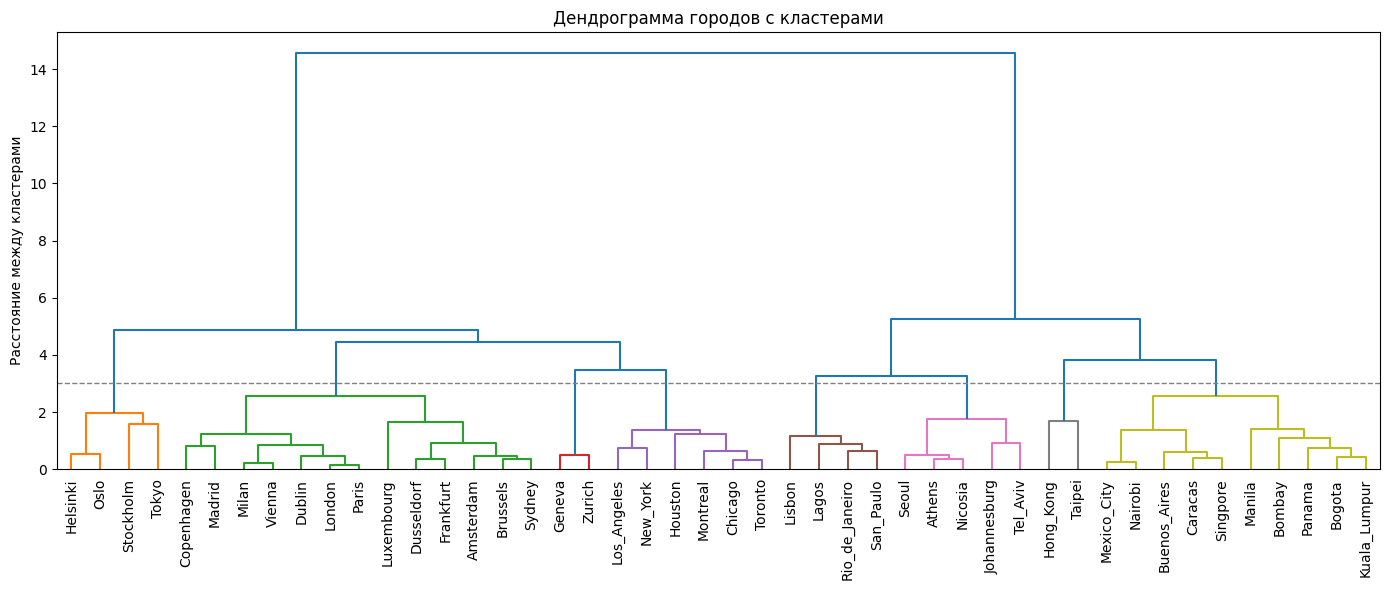

In [49]:
for height_cut in [5, 4, 3]:
    plt.figure(figsize=(14, 6))
    dendrogram(
        Z,
        labels=df['City'].values,
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=height_cut
    )
    plt.title("Дендрограмма городов с кластерами")
    plt.ylabel("Расстояние между кластерами")
    plt.axhline(y=height_cut, c='gray', lw=1, linestyle='--')
    plt.tight_layout()
plt.show()

Из полученных дендрограмм наиболее оптимальным по количеству кластеров кажется вариант с линией среза на высоте 4. В этом случае получаем 5 кластеров:

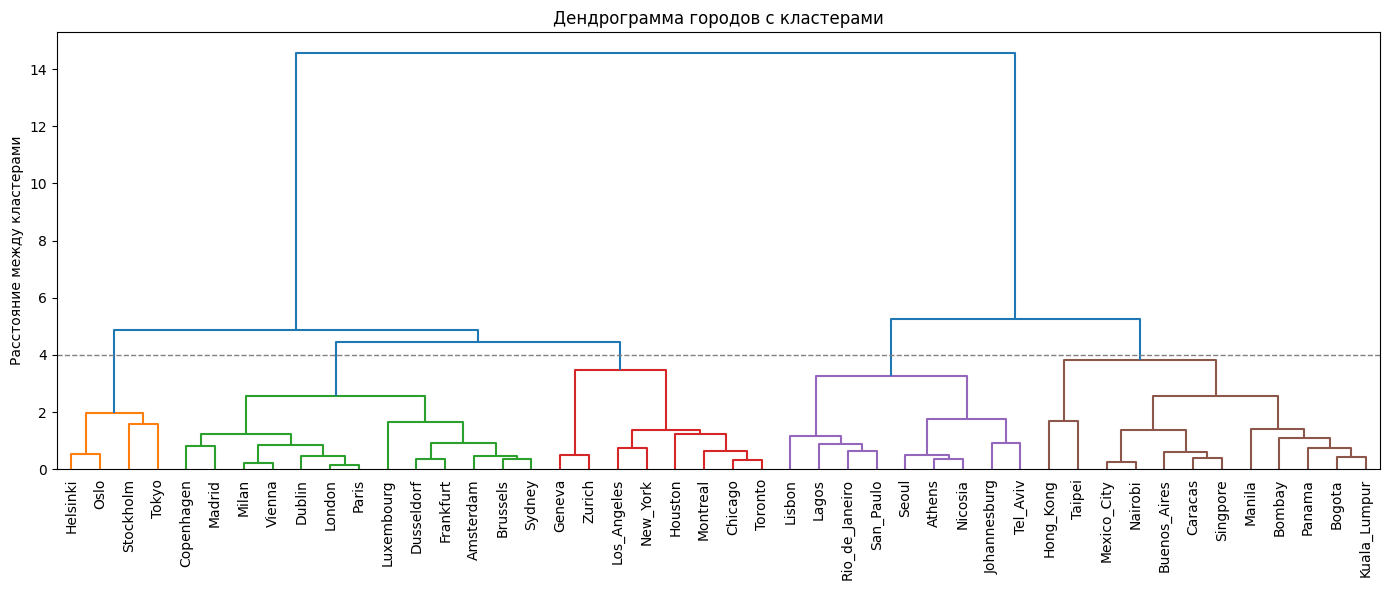

In [50]:
height_cut = 4

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df['City'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=height_cut
)
plt.title("Дендрограмма городов с кластерами")
plt.ylabel("Расстояние между кластерами")
plt.axhline(y=height_cut, c='gray', lw=1, linestyle='--')
plt.tight_layout()
plt.show()

Сохраним распределение городов по кластерам в отдельный столбец:

In [51]:
df['Hierarchical_Cluster'] = fcluster(Z, height_cut, criterion='distance')
df.head(10)

,City,Work,Price,Salary,Affordability,Hierarchical_Cluster
0,Amsterdam,1714.0,65.6,49.0,0.746951,2
1,Athens,1792.0,53.8,30.4,0.565056,4
2,Bogota,2152.0,37.9,11.5,0.303430,5
3,Bombay,2052.0,30.3,5.3,0.174917,5
4,Brussels,1708.0,73.8,50.5,0.684282,2
5,Buenos_Aires,1971.0,56.1,12.5,0.222816,5
7,Caracas,2041.0,61.0,10.9,0.178689,5
8,Chicago,1924.0,73.9,61.9,0.837618,3
9,Copenhagen,1717.0,91.3,62.9,0.688938,2
10,Dublin,1759.0,76.0,41.4,0.544737,2


In [ ]:
# df[["City", "Work", "Price", "Salary", "Affordability", "Hierarchical_Cluster"]].to_csv(
#     "cities_with_affordability.csv",
#     index=False,
#     encoding="utf-8",
#     sep=";"
# )
pd.read_csv("cities_with_affordability.csv", index_col=False, encoding="utf-8", sep=";").head(20)

,City,Work,Price,Salary,Affordability,Hierarchical_Cluster
0,Amsterdam,1714.0,65.6,49.0,0.746951,2
1,Athens,1792.0,53.8,30.4,0.565056,4
2,Bogota,2152.0,37.9,11.5,0.303430,5
3,Bombay,2052.0,30.3,5.3,0.174917,5
4,Brussels,1708.0,73.8,50.5,0.684282,2
5,Buenos_Aires,1971.0,56.1,12.5,0.222816,5
6,Caracas,2041.0,61.0,10.9,0.178689,5
7,Chicago,1924.0,73.9,61.9,0.837618,3
8,Copenhagen,1717.0,91.3,62.9,0.688938,2
9,Dublin,1759.0,76.0,41.4,0.544737,2


## Визуализация

Для полученных кластеров построим распределение, чтобы оценить полученные группы.
1) Первая диаграмма - распределение с цветным выделением количества рабочих часов;
2) Вторая диаграмма - распределение с цветным выделением кластеров.

In [55]:
fig = px.scatter(
    df,
    x='Price',
    y='Salary',
    text='City',
    size='Work',
    color='Work',
    hover_data=['Work', 'Price', 'Salary'],
    title='Зависимость Цен от Зарплаты (цвет = рабочие часы)',
    template='plotly_white'
)
fig.update_traces(textposition='top center')
fig.show()

In [56]:
fig = px.scatter(
    df,
    x="Price",
    y="Salary",
    color="Hierarchical_Cluster",
    size="Affordability",
    text="City",
    hover_data=["Work", "Price", "Salary", "Affordability"],
    color_discrete_sequence=['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink'],
    title="Распределение городов по кластерам"
)

fig.update_traces(marker=dict(size=15))
fig.update_traces(textposition="top center")

fig.show()

Здесь видно, что:
- к 5 кластеру относятся города с наиболльшим количеством рабочих часов. В основном, это бедные страны;
- к 4 классу относятся города примерно с той же доступностью, но меньши количеством раббочих часов;
- ко 2 и 3 кластеру относятся среднестатичтические города, однако в 3 кластере преобладают места с более высоким количеством рабочих часов;
- к 1 кластеру относятся города из Скандинавии, а также Токио (Япония). По поводу города скандинавии уже писалось выше - у них высокие налоги, засчёт чего чистая прибыль такая же, как и у среднестатистических городов. Объяснить такое расположение Токио можно тем, что зарплаты там остаются одними из самых высоких в Азии, особенно в IT, финансах и производстве. Это повышает значение `Salary` до уровня Скандинавии, а также то, что Токио является "дорогим" городом (особенно жильё и транспорт). Это сильно повышает показатель `Price`. Таким образом, соотношение становится схожим со Скандинавскими странами.

Чтобы наглядно отобразить, где находятся города, относящиеся к определённому кластеру, необходимо определить их координаты (широту и долготу).
Для этого будем использовать библиотеку `geopy` и сервис `Nominatim`, который обращается к открытому картографическому API OpenStreetMap и возвращает координаты по названию города.

<details>
<summary>Пояснение geopy()</summary>

- Функция `geocode()` отправляет запрос на сервер OpenStreetMap с названием города;
- В ответ возвращаются географические данные (широта и долгота);
- Эти значения записываются в новые столбцы lat и lon таблицы.

</details>

In [57]:
geolocator = Nominatim(user_agent="geo_city_locator")

def get_coords(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([np.nan, np.nan])

df[["lat", "lon"]] = df["City"].apply(get_coords)
time.sleep(1)  # чтобы не перегружать API

df.head(10)

,City,Work,Price,Salary,Affordability,Hierarchical_Cluster,lat,lon
0,Amsterdam,1714.0,65.6,49.0,0.746951,2,52.373080,4.892453
1,Athens,1792.0,53.8,30.4,0.565056,4,33.959768,-83.376398
2,Bogota,2152.0,37.9,11.5,0.303430,5,4.653382,-74.083633
3,Bombay,2052.0,30.3,5.3,0.174917,5,19.054999,72.869203
4,Brussels,1708.0,73.8,50.5,0.684282,2,50.846557,4.351697
5,Buenos_Aires,1971.0,56.1,12.5,0.222816,5,-34.609558,-58.388790
7,Caracas,2041.0,61.0,10.9,0.178689,5,10.506093,-66.914601
8,Chicago,1924.0,73.9,61.9,0.837618,3,41.875562,-87.624421
9,Copenhagen,1717.0,91.3,62.9,0.688938,2,55.686724,12.570072
10,Dublin,1759.0,76.0,41.4,0.544737,2,53.349379,-6.260559


Процесс для обработки исходного набора данных составил около минуты, поэтому сохраним таблицу в отдельный файл, чтобы избежать "узкого горлышка" в виде обращения к API и послоедовательной обработки данных:

In [58]:
df[["City", "Work", "Price", "Salary", "Affordability","lat", "lon"]].to_csv(
    "cities_with_coords.csv",
    index=False,
    encoding="utf-8",
    sep=";"
)

Теперь визуализируем результаты кластеризации городов на карте. Каждый город отображается точкой, цвет которой соответствует кластеру. Это позволяет наглядно оценить географическое распределение кластеров и понять, какие города объединяются по схожим экономическим характеристикам.

In [59]:
clusters = sorted(df['Hierarchical_Cluster'].dropna().unique())
colors = cm.get_cmap('Set1', len(clusters))
color_map = {c: mcolors.rgb2hex(colors(i)) for i, c in enumerate(clusters)}

m = folium.Map(location=[55, 10], zoom_start=3, tiles='CartoDB Voyager')

for cluster in clusters:
    fg = folium.FeatureGroup(name=f"Кластер {cluster}")
    
    for _, row in df[df['Hierarchical_Cluster'] == cluster].dropna(subset=["lat", "lon"]).iterrows():
        tooltip = (
            f"{row['City']} ({cluster})<br>"
            f"Price: {row['Price']}<br>"
            f"Salary: {row['Salary']}<br>"
            f"Affordability: {row['Affordability']:.2f}"
        )
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=7,
            color=color_map[cluster],
            fill=True,
            fill_color=color_map[cluster],
            fill_opacity=0.8,
            tooltip=tooltip
        ).add_to(fg)
    
    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

display(m)

На карте действительно видно, что доступность больше в кластере 3, которому соответствуют города в богатых областях США и Каналы а также в Цюрихе и Женеве. Остальные кластеру тоже соответствуют описанию выше.

## Ответ

Датасет содержит небольшое количество данных, поэтому для его анализа исопльщовалась иерархическая кластеризация с визуализацией на дендрограммах.

Всего было выделено 5 кластеров:
- к 5 кластеру относятся города с наиболльшим количеством рабочих часов. В основном, это бедные страны;
- к 4 классу относятся города примерно с той же доступностью, но меньши количеством раббочих часов;
- ко 2 и 3 кластеру относятся среднестатичтические города, однако в 3 кластере преобладают места с более высоким количеством рабочих часов;
- к 1 кластеру относятся города из Скандинавии, а также Токио (Япония). По поводу города скандинавии уже писалось выше - у них высокие налоги, засчёт чего чистая прибыль такая же, как и у среднестатистических городов. Объяснить такое расположение Токио можно тем, что зарплаты там остаются одними из самых высоких в Азии, особенно в IT, финансах и производстве. Это повышает значение `Salary` до уровня Скандинавии, а также то, что Токио является "дорогим" городом (особенно жильё и транспорт). Это сильно повышает показатель `Price`. Таким образом, соотношение становится схожим со Скандинавскими странами.

## Дополнительные источники

В ходе выполнения работы использовались дополнительные материалы, кроме лекций и тех, что были перечислены в предыдущей работе:
1. 